# Projet 5 : Segmentez des clients d'un site e-commerce

L'objectif du projet est d'établir un contrat de maintenance de l'algorithme de segmentation client, nous devons tester sa stabilité dans le temps et voir, par exemple, à quel moment les clients changent de Cluster.

## Sommaire:

## - I/ Importation des données
   
## - II/ Contrat de maintenance

## I/ Importation des données

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import datetime
from sklearn.datasets import make_blobs
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn import metrics
import seaborn as sns


In [2]:
print("version numpy :" + np.__version__)
print("version pandas :" + pd.__version__)
print("version seaborn :" + sns.__version__)

version numpy :1.20.1
version pandas :1.2.4
version seaborn :0.11.1


In [3]:
data_init = pd.read_csv("data_nettoye.csv", sep=",", parse_dates=False)

In [4]:
#on va supprimer les features qui ont une forte corrélation entre elles
data_init = data_init.drop(["price","Qty_pdt_customer","freight_value","order_id"], axis=1)
#On va supprimer les features qui ne correspondent pas au "data_rfm_rs"
data_init = data_init.drop(["payment_sequential_count","payment_installments_sum","sales","Avg_delivery"], axis=1)

In [5]:
data_init.head(5)

,customer_unique_id,review_score_mean,order_purchase_timestamp,Avg_purchases,Avg_qty_prod_order,last_purchase_delay
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,2018-05-10 10:56:27,129.90,1.0,111.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,2018-05-07 11:11:27,18.90,1.0,114.0
2,0000f46a3911fa3c0805444483337064,3.0,2017-03-10 21:05:03,69.00,1.0,536.0
3,0000f6ccb0745a6a4b88665a16c9f078,4.0,2017-10-12 20:29:41,25.99,1.0,320.0
4,0004aac84e0df4da2b147fca70cf8255,5.0,2017-11-14 19:45:42,180.00,1.0,287.0


In [6]:
data_init.set_index('customer_unique_id', inplace=True)

In [7]:
data_init.isna().sum()

review_score_mean           0
order_purchase_timestamp    0
Avg_purchases               0
Avg_qty_prod_order          0
last_purchase_delay         0
dtype: int64

In [8]:
data_init.shape

(109413, 5)

In [9]:
data_init.dtypes

review_score_mean           float64
order_purchase_timestamp     object
Avg_purchases               float64
Avg_qty_prod_order          float64
last_purchase_delay         float64
dtype: object

In [10]:
#data_init['order_purchase_timestamp'] = data_init['order_purchase_timestamp'].astype('datetime64')
data_init['order_purchase_timestamp'] = pd.to_datetime(data_init['order_purchase_timestamp'],dayfirst=True, errors='coerce')

In [11]:
data_init.dtypes

review_score_mean                  float64
order_purchase_timestamp    datetime64[ns]
Avg_purchases                      float64
Avg_qty_prod_order                 float64
last_purchase_delay                float64
dtype: object

In [12]:
#période analysée (date 1ère cde et dernière cde)
print("La période analysée commence le " + str(data_init['order_purchase_timestamp'].min())+" et se termine le " +str(data_init['order_purchase_timestamp'].max()))
print("La période dure :" +str(data_init['order_purchase_timestamp'].max()-data_init['order_purchase_timestamp'].min()))

La période analysée commence le 2016-10-03 16:56:50 et se termine le 2018-08-29 15:00:37
La période dure :694 days 22:03:47


## II/ Contrat de maintenance

In [13]:
data_init = data_init[data_init['order_purchase_timestamp'] > '2017-08-29 15:00:37']

In [14]:
data_prim = data_init.copy()
del data_prim['order_purchase_timestamp']
data_prim.shape

(62966, 4)

### - Méthodologie pour calculer la stabilité

- Création d'un dataset RFM a t0
- Fit d'un KMeans sur ce dataset a t0
- Création d'un dataset RFM à t0+n
- Fit d'un KMeans sur ce dataset à t0+n
- comparer:
   - ARI en comparant le predict du KMeans(t0) au fit  du KMeans(t0+n) sur le dataset t0+n pour les deux.

### - Stabilité temporelle du clustering 

In [15]:
# Kmeans T0 sur aout 2017 à aout 2018
num_columns_primo = data_prim.select_dtypes(include=['int32','int64','float64']).columns
data_prim[num_columns_primo] = MinMaxScaler().fit_transform(data_prim[num_columns_primo])
kmeans_primo = KMeans(n_clusters=4, n_init=1, init='random').fit(data_prim[num_columns_primo])
primo_labels = kmeans_primo.labels_
#kmeans_primo = Pipeline([("preprocess", MinMaxScaler()),("kmeans", KMeans(K, random_state=42))])
#kmeans_primo.fit(data_prim)
#primo_labels = kmeans_primo.named_steps['kmeans'].labels_

In [16]:
score_ari = []
k_cluster = []
for i in range(1,15):
       
        #Création des datasets par periode t0+i
        date_delta_i = data_init['order_purchase_timestamp'].max() - i*np.timedelta64(1,'M')
        period_i=data_init[data_init['order_purchase_timestamp'] > date_delta_i]
        del period_i["order_purchase_timestamp"]
        
        #T0+i     
        #num_columns = period_i.select_dtypes(include=['int32','int64','float64']).columns
        period_i = MinMaxScaler().fit_transform(period_i)
        kmeans_i = KMeans(n_clusters=4, n_init=1, init='random').fit(period_i)
        
        #preprocess = ColumnTransformer([('mms', MinMaxScaler(), num_columns)])
        #kmeans_i = Pipeline([("preprocessor", preprocess),("kmeans", KMeans(K, random_state=42))])
        #kmeans_i.fit_transform(period_i)
        #labels_i = kmeans_i.named_steps['kmeans'].labels_
            
        labels_i = kmeans_i.labels_
        pred_i = kmeans_primo.predict(period_i)

        #Calcul du Score ARI
        ari_i = metrics.adjusted_rand_score( pred_i,labels_i)
        score_ari.append([i,ari_i])
score_ari = pd.DataFrame(score_ari, columns=['Mois','Score ARI'])       

/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/s

### - Graphique

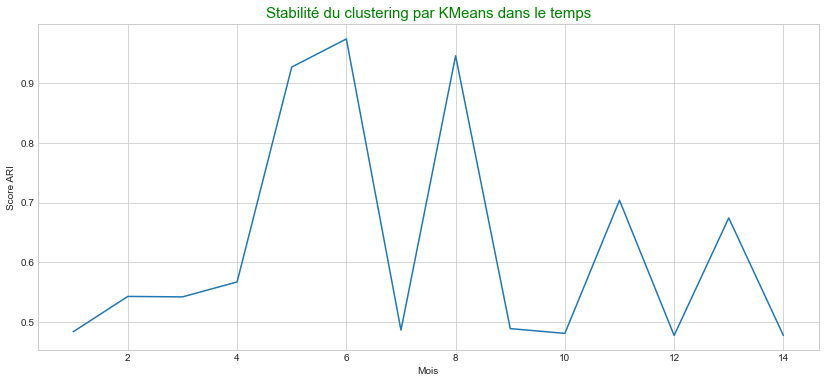

In [17]:
fig = plt.figure(figsize=(14,6))
sns.lineplot(data=score_ari, x="Mois", y="Score ARI")

plt.xlabel("Mois")
plt.ylabel("Score ARI")
plt.title("Stabilité du clustering par KMeans dans le temps",fontsize=15,color="green")
plt.show()

- Sur ce graphe, on a les scores ARI obtenus sur des itérations par période d'un mois, on constate une forte inflexion après 6 mois sur les clients de référence.

- Il faudra donc prévoir la maintenance du programme de segmentation tous les 7 mois dans un premier temps puis re-tester cette stabilité afin de l'améliorer. Il faudra donc redéfinir les segments clients à chaque maintenance.